# Impact Aware Embeddings
1. loading textual and price datasets
2. labeling the price dataset and merging it with the textual dataset
3. evaluating the base model on the labels
4. finetuning the embedding model on labelings to make it impact-aware

In [1]:
# imports
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, TrainerCallback
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
from datetime import timedelta
import plotly.graph_objects as go
from datasets import Dataset
from torch.utils.data import DataLoader, Dataset as torchDS
import mlflow
from mlflow import log_metric, log_param, sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from functools import partial
from scipy.special import softmax
import torch

In [13]:
# internal imports
import sys
import os
current_working_directory = os.getcwd()
sys.path.append(os.path.dirname(current_working_directory))
from src.util import *

In [3]:
# setting mlflow parameters
mlflow.set_tracking_uri(uri="https://mlflow.finbright.org/")
mlflow.set_experiment("base_tbl_1000")

<Experiment: artifact_location='/mlruns/1', creation_time=1712675940440, experiment_id='1', last_update_time=1712675940440, lifecycle_stage='active', name='base_tbl_1000', tags={}>

### reading textual and price datasets

In [5]:
# reading embedded textual dataset which should contain (date, text, embeddings)
# TODO: generate the dataset if it doesn't exist
text_df = pd.read_csv("../raw/combined_tweets_2020_labeled.csv", usecols=["date", "text_split"])
text_df.rename(columns={"text_split": "text"}, inplace=True)
text_df.set_index('date', inplace=True)
text_df.index = pd.to_datetime(text_df.index)

In [6]:
# reading price data
price_df = pd.read_csv("../raw/daily-2020.csv", usecols=["timestamp", "close", "open", "high", "low", "volume"])
price_df.set_index('timestamp', inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit='s')

In [28]:
text_df.shape

(64310, 1)

In [29]:
price_df.shape

(366, 5)

### labeling the price dataset and merging with textual dataset

In [14]:
tbl = triple_barrier_labeling(price_df)

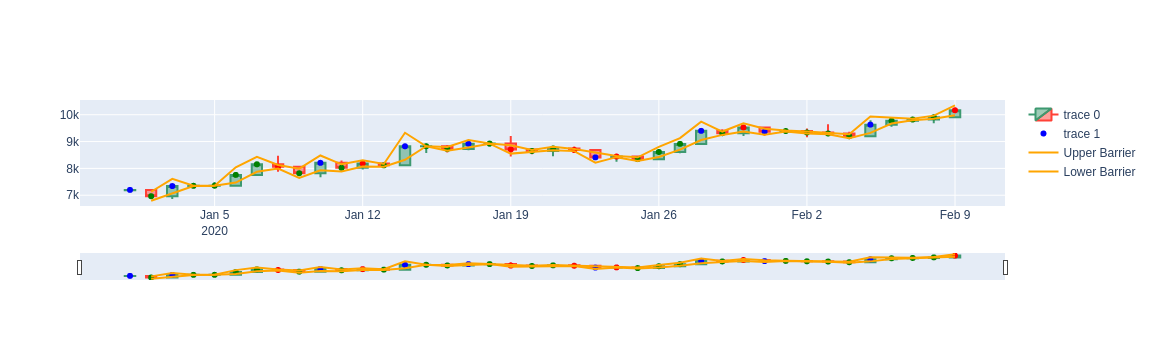

In [15]:
plot_df = tbl.iloc[0:40]
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=tbl.index,
                                     open=plot_df['open'], 
                                     high=plot_df['high'],
                                     low=plot_df['low'], 
                                     close=plot_df['close'],
                                     hovertext=['Open: {}<br>High: {}<br>Low: {}<br>Close: {}'.format(o, h, l, c) for o, h, l, c in zip(plot_df['open'], plot_df['high'], plot_df['low'], plot_df['close'])],
                                     hoverinfo='text')])

# Add the labels to the plot as a scatter plot overlay
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['close'], mode='markers', 
                         marker=dict(color=plot_df['label'].map({2: 'green', 0: 'red', 1: 'blue'}))))

# Add the upper and lower barriers to the plot
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['upper_barrier'], name='Upper Barrier', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['lower_barrier'], name='Lower Barrier', line=dict(color='orange')))

fig.show()
del(plot_df)

In [ ]:
labeled_df = text_df.merge(tbl[['label']], left_index=True, right_index=True, how='left')

In [ ]:
dataset = Dataset.from_pandas(labeled_df[['text', 'label']])

In [ ]:
# shuffeling the dataset for a more unbiased mix
shuffled_dataset = dataset.shuffle(seed=42)

### evaluating the base model on the labels

In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = softmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

In [33]:
# Tokenize the text field in the dataset
def tokenize_function(tokenizer, examples):
    # Tokenize the text and return only the necessary fields
    encoded = tokenizer(examples["text"], padding='max_length', max_length=512)
    return {"input_ids": encoded["input_ids"], "attention_mask": encoded["attention_mask"], "label": examples["label"]}

In [34]:
# tokenizing the dataset text to be used in train and test loops
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
partial_tokenize_function = partial(tokenize_function, tokenizer)
tokenized_datasets = shuffled_dataset.map(partial_tokenize_function, batched=True)

Map:   0%|          | 0/64310 [00:00<?, ? examples/s]

In [37]:
# Spliting the dataset for evaluation
subset = tokenized_datasets.select(range(100))

In [38]:
# Load the non-fine-tuned model
non_fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels=3)
non_fine_tuned_training_args = TrainingArguments(
    output_dir="../artifact"
)
non_fine_tuned_trainer = Trainer(
    model=non_fine_tuned_model,         # the non-fine-tuned model
    args=non_fine_tuned_training_args,  # training arguments, defined above
    eval_dataset=subset,                # test dataset
    compute_metrics=compute_metrics,    # the compute_metrics function
)

In [42]:
# Start a new MLflow run
with mlflow.start_run(description="tbl labeling, 500 shuffled dataset", log_system_metrics=False):
    # Train and evaluate the model
    # non_fine_tuned_trainer.train()
    non_fine_tuned_eval_result = non_fine_tuned_trainer.evaluate()

    # Log the model
    mlflow.pytorch.log_model(non_fine_tuned_model, "model")

    # Log parameters
    log_param("num_labels", 3)

    # Log metrics
    for key, value in non_fine_tuned_eval_result.items():
        log_metric(key, value)

KeyboardInterrupt: 

### finetuning the embedding model on labelings to make it impact-aware

In [ ]:
class TextDataset(torchDS):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['label'])
        }

In [ ]:
# could be used inside the huggingface trainer api
class MlflowLoggingCallback(TrainerCallback):
    "A callback that logs metrics to MLflow"

    def on_step_end(self, args, state, control, model=None, optimizer=None, **kwargs):
        # Evaluate each step
        step = state.global_step

In [ ]:
def calculate_and_log_metrics(labels, preds, probs, step):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr')  # Use probabilities here

    # Log the metrics with MLflow
    mlflow.log_metric("accuracy", acc, step=step)
    mlflow.log_metric("f1", f1, step=step)
    mlflow.log_metric("precision", precision, step=step)
    mlflow.log_metric("recall", recall, step=step)
    mlflow.log_metric("roc_auc", roc_auc, step=step)

In [ ]:
subset = tokenized_datasets.select(range(200))

In [ ]:
subset_split = subset.train_test_split(0.2)

In [ ]:
train_dataset = TextDataset(subset_split['test'])
test_dataset = TextDataset(subset_split['test'])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=5)

In [ ]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels=3)

In [ ]:
learning_rate = 1e-5
epochs = 5

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Move the model to the device
fine_tuned_model.to(device)
# Set up the optimizer
optimizer = AdamW(fine_tuned_model.parameters(), lr=learning_rate)

# Start a new MLflow run
with mlflow.start_run(description="tbl labeling, 200 items, 5 epochs, full metrics, shuffled dataset, fine tuned"):
    # Training loop
    for epoch in tqdm(range(epochs)):  # Number of epochs
        all_labels = []
        all_preds = []
        all_probs = []  # For storing probabilities
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = fine_tuned_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            # Log metrics with MLflow
            mlflow.log_metric("train_loss", loss.item(), step=epoch)
            
            # Store labels, predictions and probabilities for metrics calculation
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_probs.append(preds.detach().cpu().numpy())  # Store probabilities
            class_preds = torch.argmax(preds, dim=-1)
            all_preds.append(class_preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
        # Calculate and log metrics after each epoch
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        all_probs = np.concatenate(all_probs)  # Concatenate probabilities
        calculate_and_log_metrics(all_labels, all_preds, all_probs, step=epoch)

    # Evaluation loop
    eval_loss = 0
    all_labels = []
    all_preds = []
    all_probs = []  # For storing probabilities
    for batch in tqdm(test_dataloader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = fine_tuned_model(input_ids, attention_mask=attention_mask, labels=labels)
            eval_loss += outputs.loss.item()
            all_labels.append(labels.cpu().numpy())
            # Get the predicted probabilities from the model's outputs
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_probs.append(preds.cpu().numpy())  # Store probabilities
            # Convert the probabilities to class labels
            class_preds = torch.argmax(preds, dim=-1)
            all_preds.append(class_preds.cpu().numpy())
    
    # Calculate metrics
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)  # Concatenate probabilities
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # Use probabilities here
    
    # Log the evaluation loss and metrics with MLflow
    mlflow.log_metric("eval_loss", eval_loss / len(test_dataloader), step=epoch)
    mlflow.log_metric("accuracy", acc, step=epoch)
    mlflow.log_metric("f1", f1, step=epoch)
    mlflow.log_metric("precision", precision, step=epoch)
    mlflow.log_metric("recall", recall, step=epoch)
    mlflow.log_metric("roc_auc", roc_auc, step=epoch)
    
    # Save and log the model with MLflow
    # torch.save(fine_tuned_model.state_dict(), "model.pth")
    mlflow.pytorch.log_model(fine_tuned_model, "model")


In [ ]:
# Start a new MLflow run
with mlflow.start_run(description="tbl labeling, 500 shuffled dataset, fine tuned"):
    # Train and evaluate the model
    training_results = trainer.train()
    fine_tuned_eval_result = trainer.evaluate()

    # Log the model
    mlflow.pytorch.log_model(fine_tuned_model, "model")

    # Log parameters
    log_param("num_labels", 3)

    # Log metrics
    for key, value in fine_tuned_eval_result.items():
        log_metric(key, value)

huggingface trainer api for the same task

In [ ]:
# # Define the training arguments
# training_args = TrainingArguments(
#     output_dir='../artifact',          # output directory
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=5,  # batch size per device during training
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='../log',            # directory for storing logs
# )

# # Create the Trainer and train
# trainer = Trainer(
#     model=fine_tuned_model,                       # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                # training arguments, defined above
#     train_dataset=subset_split['train'],    # train dataset
#     eval_dataset=subset_split['test'],      # test dataset
#     compute_metrics=compute_metrics,
#     callbacks=[MlflowLoggingCallback],  # add the callback
# )